# Preparation

### Import, constants and functions

In [2]:
import numpy as np
from numpy.random import seed
#seed(12345)

import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import Sequence

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from google.colab import drive
from google.colab.patches import cv2_imshow

In [3]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [4]:
def show_results(history):
  # Show training history (this cell is complete, nothing to implement here :-) )
  h = history.history
  epochs = range(len(h['loss']))

  plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
  plt.legend(['Train', 'Validation'])
  plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                            epochs, h['val_accuracy'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

  print('Train Acc     ', h['accuracy'][-1])
  print('Validation Acc', h['val_accuracy'][-1])

In [5]:
def comparison(test_dataset, decoded_imgs, n):
  for ii in range(n):
      image_num = np.random.randint(0, len(test_dataset))

      plt.subplot(2,n,ii+1), plt.imshow(test_dataset[image_num, ...])
      plt.title("original")

      plt.subplot(2,n,ii+1+n), plt.imshow(decoded_imgs[image_num, ...])
      plt.title("reconstructed")

In [6]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [7]:
# Load data from the folder
with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data/train_dataset.npy', 'rb') as f:
    train_dataset = np.load(f)

with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data/test_dataset.npy', 'rb') as f:
    test_dataset = np.load(f)

In [8]:
hight = train_dataset.shape[1]
width = train_dataset.shape[2]

### Data inspaction

In [9]:
print('Train set:   ', len(train_dataset), 'samples')
print('Test set:    ', len(test_dataset), 'samples')
print('Sample dims: ', train_dataset.shape)

Train set:    4310 samples
Test set:     1437 samples
Sample dims:  (4310, 54, 96, 3)


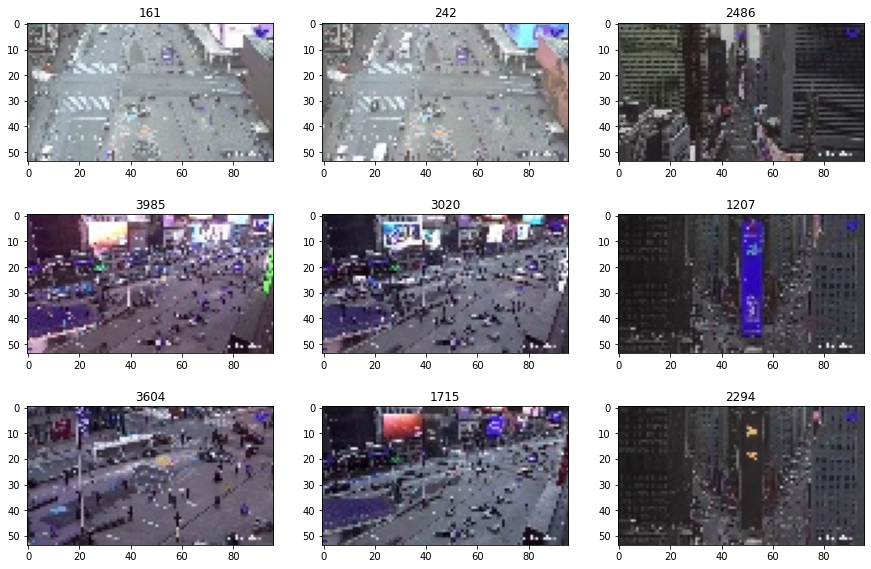

In [10]:
# Show random samples
for ii in range(9):
    image_num = np.random.randint(0, len(train_dataset))
    plt.subplot(3,3,ii+1), plt.imshow(train_dataset[image_num, ...])
    plt.title(str(image_num))

#Building model

In [11]:
# Normalization
train_dataset = train_dataset.astype('float32')/255
test_dataset = test_dataset.astype('float32')/255

## Create model

In [12]:
latent_dim = 5000 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
        #layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.Flatten(),
        layers.Dense(latent_dim, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(width*hight*3, activation='sigmoid'),
      layers.Reshape((hight, width, 3))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [13]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=["accuracy"])

In [14]:
epochs = 50
batch_size = 16
history = autoencoder.fit(DataGenerator(train_dataset, train_dataset, batch_size),
                epochs=epochs,
                shuffle=True,
                validation_data=(DataGenerator(test_dataset, test_dataset, batch_size)))

Epoch 1/50
270/270 [==============================] - 10s 36ms/step - loss: 0.0402 - accuracy: 0.5142 - val_loss: 0.0275 - val_accuracy: 0.6461
Epoch 2/50
270/270 [==============================] - 10s 36ms/step - loss: 0.0245 - accuracy: 0.6572 - val_loss: 0.0220 - val_accuracy: 0.6990
Epoch 3/50
270/270 [==============================] - 10s 36ms/step - loss: 0.0221 - accuracy: 0.6990 - val_loss: 0.0204 - val_accuracy: 0.7053
Epoch 4/50
270/270 [==============================] - 10s 36ms/step - loss: 0.0202 - accuracy: 0.7009 - val_loss: 0.0192 - val_accuracy: 0.6973
Epoch 5/50
270/270 [==============================] - 10s 36ms/step - loss: 0.0200 - accuracy: 0.6949 - val_loss: 0.0188 - val_accuracy: 0.7059
Epoch 6/50
270/270 [==============================] - 10s 35ms/step - loss: 0.0195 - accuracy: 0.7021 - val_loss: 0.0192 - val_accuracy: 0.7003
Epoch 7/50
270/270 [==============================] - 10s 36ms/step - loss: 0.0189 - accuracy: 0.6987 - val_loss: 0.0222 - val_accuracy:

Train Acc      0.7125993967056274
Validation Acc 0.6904338002204895


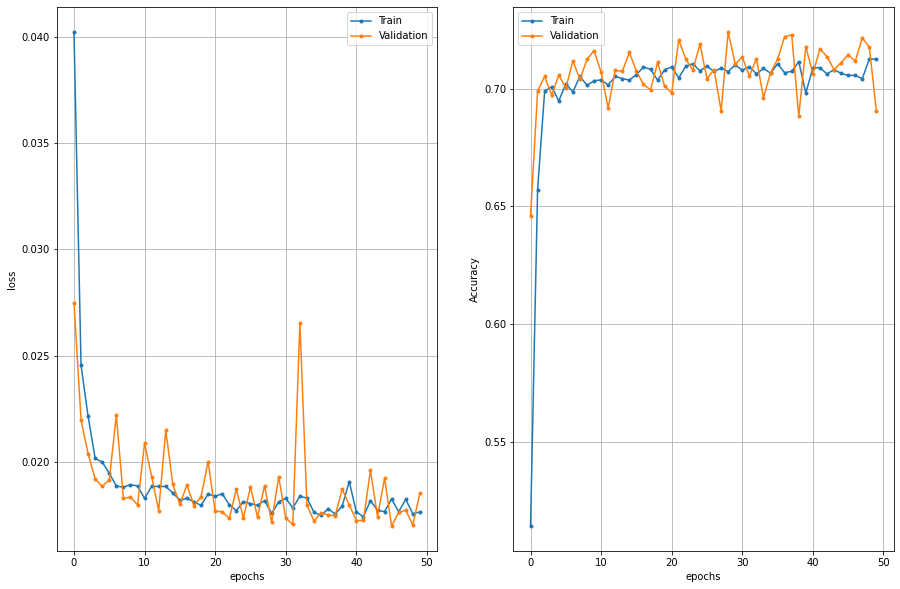

In [15]:
show_results(history)

In [16]:
encoded_imgs = autoencoder.encoder(test_dataset).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

with open('drive/MyDrive/Colab Notebooks/encoded_imgs.npy', 'wb') as f:
    np.save(f, encoded_imgs)

In [17]:
print('Sample encoded: ', encoded_imgs.shape)
print('Sample decoded: ', decoded_imgs.shape)
print('comression: ', decoded_imgs.shape[1]*decoded_imgs.shape[2]*decoded_imgs.shape[3]/encoded_imgs.shape[1])

Sample encoded:  (1437, 5000)
Sample decoded:  (1437, 54, 96, 3)
comression:  3.1104


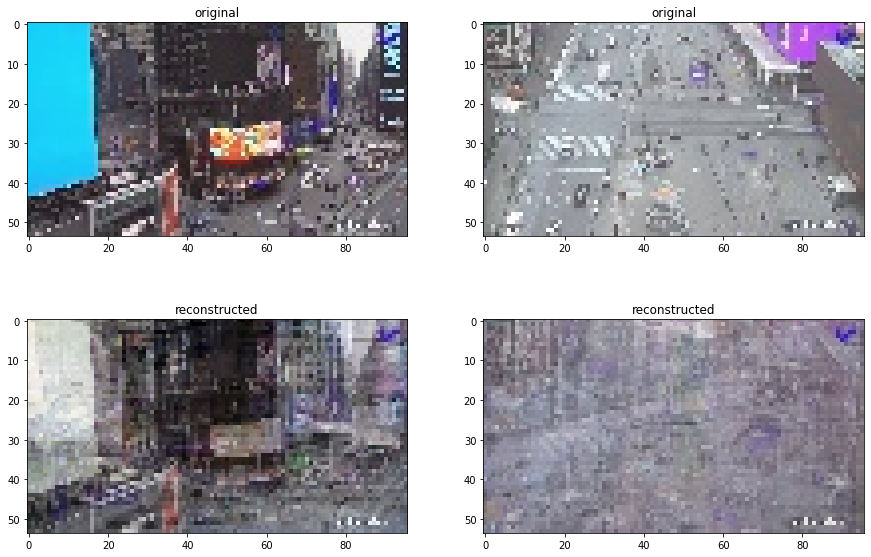

In [18]:
# Show random comparison
comparison(test_dataset, decoded_imgs, 2)